In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['axes.labelsize'] = 14

# Neural Networks


## Activation functions



In [8]:
# the common activation functions:

def logistic(x):
    return 1/(1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(x, 0)

# and their derivatives:

def tanh_deriv(x):
    return 1.0 - np.tanh(x)**2

def logistic_deriv(x):
    return logistic(x)*(1-logistic(x))

def relu_deriv(x) :
    deriv = x.copy()
    deriv[deriv < 0] = 0
    return deriv


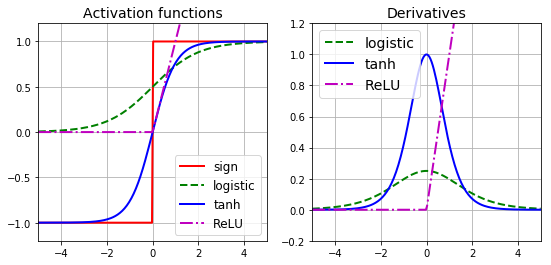

In [6]:
x = np.linspace(-5, 5, 200)
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.plot(x, np.sign(x), "r-", linewidth=2, label="sign")
plt.plot(x, logistic(x), "g--", linewidth=2, label="logistic");
plt.plot(x, np.tanh(x), "b-", linewidth=2, label="tanh");
plt.plot(x, relu(x), "m-.", linewidth=2, label="ReLU");
plt.grid(True);
plt.legend(fontsize=12);
plt.title("Activation functions", fontsize=14);
plt.axis([-5, 5, -1.2, 1.2]);

plt.subplot(122)
plt.plot(x, logistic_deriv(x), "g--", linewidth=2, label="logistic")
plt.plot(x, tanh_deriv(x), "b-", linewidth=2, label="tanh")
plt.plot(x, relu_deriv(x), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.savefig('activation_functions.png')




## The XOR learning problem

The XOR problem is an example of data that is not linearly separable:

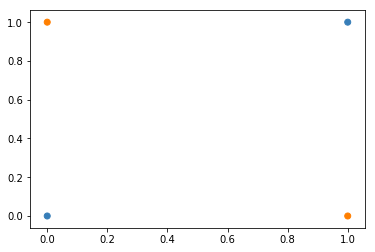

In [4]:
X = np.array( [[0,0], [0,1], [1,0], [1,1]])
y = np.array([0,1,1,0])
colors = np.array(['#377eb8', '#ff7f00'])
plt.scatter(X[:, 0], X[:, 1], color=colors[y])

Let's demonstrate that this problem can be solved with a very simple neural network:

In [5]:
def mlp_xor(x1, x2, activation=tanh):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)


Text(0.5,1,'XOR network with tanh activation')

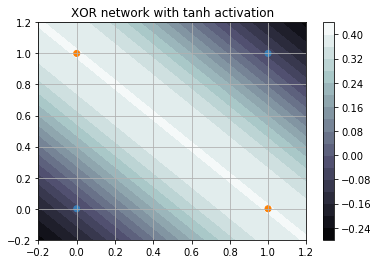

In [6]:
x1_values = np.linspace(-0.2, 1.2, 100)
x2_values = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1_values, x2_values)

z = mlp_xor(x1, x2, activation=tanh)

plot=plt.contourf(x1, x2, z, 20, cmap=plt.cm.bone)
plt.colorbar(plot)

plt.scatter(X[:, 0], X[:, 1], color=colors[y])
plt.title("XOR network with tanh activation", fontsize=12)
plt.grid(True)

You can also solve this problem with the ReLu activation fuction:

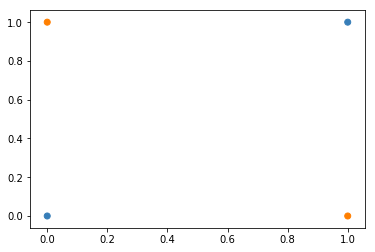

In [7]:

def relu(x):
    return np.maximum(x, 0)

w1 = np.ones((2,2))
b1 = np.array([0, -1])
w2 = np.array([1, -2])
b2 = 0

y_pred = relu(X.dot(w1) + b1).dot(w2) + b2

# plot the output generated by the network:
y_pred = np.array(y_pred, dtype='int')
plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred])


Let's look at the representation that was used to classify the data:

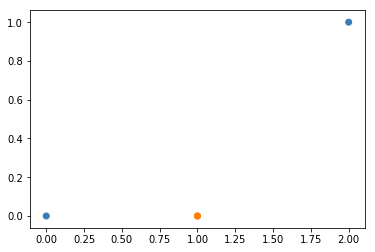

In [8]:
h = relu(X.dot(w1) + b1)
plt.scatter(h[:, 0], h[:, 1], color=colors[y])

In [9]:
class NeuralNetwork :
    def __init__(self, architecture, activation='logistic') :
        self.architecture = architecture
        if activation == 'logistic':
            self.activation = logistic
            self.activation_deriv = logistic_deriv
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_deriv = tanh_deriv
        else :
            raise ValueError('Activation does not match options')
        self.initialize_weights()
        
    def initialize_weights(self) :
        W = {}
        b = {}
        for l in range(1, len(self.architecture)):
            W[l] = np.random.random((self.architecture[l], self.architecture[l-1]))
            b[l] = np.random.random((self.architecture[l],))
            #W[l] = np.random.randn(self.architecture[l], self.architecture[l-1])
            #b[l] = np.random.randn(self.architecture[l])
        self.W, self.b = W, b

    def forward(self, x):
        h = {1: x}
        s = {}
        for l in range(1, len(self.W) + 1):
            s[l+1] = self.W[l].dot(h[l]) + self.b[l]
            h[l+1] = self.activation(s[l+1])
        return h, s
        
    def init_delta_values(self):
        delta_W = {}
        delta_b = {}
        for l in range(1, len(self.architecture)):
            delta_W[l] = np.zeros((self.architecture[l], self.architecture[l-1]))
            delta_b[l] = np.zeros((self.architecture[l],))
        return delta_W, delta_b

    def calculate_output_layer_delta(self, y, h_out, s_out):
        return -(y-h_out) * self.activation_deriv(s_out)

    def calculate_hidden_delta(self, delta_plus_1, w_l, s_l):
        # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(s^(l))
        return np.dot(np.transpose(w_l), delta_plus_1) * self.activation_deriv(s_l)

    def fit(self, X, y, num_iterations=3000, alpha=0.25):
        iterations = 0
        N = len(y)
        avg_cost_func = []
        print('Starting gradient descent for {} iterations'.format(num_iterations))
        while iterations < num_iterations :
            if iterations%200 == 0:
                print('Iteration {} of {}'.format(iterations, num_iterations))
                if len(avg_cost_func) > 0 :
                    print('cost: ', avg_cost_func[-1])
            delta_W, delta_b = self.init_delta_values()
            avg_cost = 0
            for i in range(len(y)):
                delta = {}
                # perform the feed forward pass and return the stored h and z values, to be used in the
                # gradient descent step
                h, s = self.forward(X[i, :])
                # backpropagate the errors
                for l in range(len(self.architecture), 0, -1):
                    if l == len(self.architecture):
                        delta[l] = self.calculate_output_layer_delta(y[i,:], h[l], s[l])
                        avg_cost += (np.linalg.norm((y[i,:]-h[l])) / N)
                    else:
                        if l > 1:
                            delta[l] = self.calculate_hidden_delta(delta[l+1], self.W[l], s[l])
                        delta_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis]))
                        delta_b[l] += delta[l+1]
            # perform the gradient descent step for the weights in each layer
            for l in range(len(self.architecture) - 1, 0, -1):
                self.W[l] += -alpha * (1.0/N * delta_W[l])
                self.b[l] += -alpha * (1.0/N * delta_b[l])
            # complete the average cost calculation
            avg_cost_func.append(avg_cost)
            iterations += 1
        return avg_cost_func

    def predict(self, X):
        N = X.shape[0]
        y = np.zeros((N,))
        for i in range(N):
            h, _ = self.forward(X[i, :])
            y[i] = np.argmax(h[len(self.architecture)])
        return y

    def decision_function(self, X):
        N = X.shape[0]
        scores = np.zeros((N,self.architecture[-1]))
        for i in range(N):
            h, _ = self.forward(X[i, :])
            scores[i]=h[len(self.architecture)]
        return scores


In [20]:

architecture = [2, 3, 2]
network = NeuralNetwork(architecture)
X = np.random.randn(10, 2)
network.decision_function(X)


array([[0.85019411, 0.69127531],
       [0.87179556, 0.72443905],
       [0.89160756, 0.75725105],
       [0.8697123 , 0.72341725],
       [0.87514896, 0.74613577],
       [0.89384169, 0.76992416],
       [0.82846256, 0.66489114],
       [0.89772482, 0.76756917],
       [0.88307498, 0.75965422],
       [0.90397499, 0.77779621]])

Let's apply the network to a digit recognition problem.  But before we do so, let's see how well we can do with an SVM...

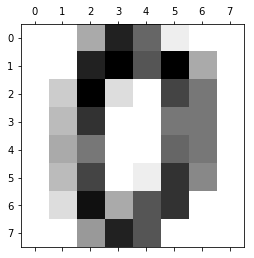

0.9533150313252075

In [9]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn import metrics

digits = load_digits()

plt.matshow(digits.images[0], cmap=plt.cm.gray_r)
plt.show()

digits = load_digits()
X_scale = StandardScaler()
#X = X_scale.fit_transform(digits.data)
X = digits.data / digits.data.max()
y = digits.target

from sklearn.model_selection import GridSearchCV
C_list = np.logspace(-2, 2, 10)
classifier = GridSearchCV(svm.SVC(kernel='linear'), dict(C=C_list), cv=5)
cv_results_nested = cross_validate(classifier, X, y, cv=5, scoring='accuracy')
np.mean(cv_results_nested['test_score'])


In [4]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

digits = load_digits()
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)
#X = digits.data / digits.data.max()
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
# convert labels to vectors
y_vec_train = y_to_vect(y_train)
y_vec_test = y_to_vect(y_test)
X_train[:,0]

array([0., 0., 0., ..., 0., 0., 0.])

In [41]:
# the NN architecture
# architecture = [64, 30, 10]
# # train the NN
# network = NeuralNetwork(architecture, 'logistic')
# cost_func = network.fit(X_train, y_vec_train, 400)
# y_pred = network.predict(X_test)
# print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))
# plot the avg_cost_func
# plt.plot(cost_func)
accuracies=[]
hidden_layers=[]
for i in range(1,5):
    architecture = [64, i*2, 10]
    print(architecture)
    network = NeuralNetwork(architecture, 'logistic')
    cost_func = network.fit(X_train, y_vec_train, 400)
    y_pred = network.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    hidden_layers.append(architecture[1])
    

[64, 2, 10]
Starting gradient descent for 400 iterations
Iteration 0 of 400
Iteration 200 of 400
cost:  0.9622354893519185
[64, 4, 10]
Starting gradient descent for 400 iterations
Iteration 0 of 400
Iteration 200 of 400
cost:  0.9669082800830175
[64, 6, 10]
Starting gradient descent for 400 iterations
Iteration 0 of 400
Iteration 200 of 400
cost:  0.9635625750571162
[64, 8, 10]
Starting gradient descent for 400 iterations
Iteration 0 of 400
Iteration 200 of 400
cost:  0.9554616346235746


Text(0.5,1,'Accuracy for different hidden layers')

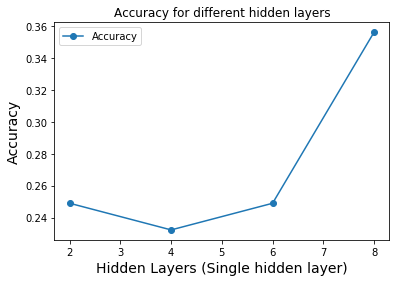

In [47]:
plt.plot(hidden_layers,accuracies,'o-',label="Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Hidden Layers (Single hidden layer)')
plt.legend()
plt.title("Accuracy for different hidden layers")

In [6]:
def mnist_loader():
    X_train = np.genfromtxt("MNIST_train.csv", delimiter=",")
    X_test = np.genfromtxt("MNIST_test.csv", delimiter=",")
    Y_train = np.genfromtxt("MNIST_train_labels.csv", delimiter=",")
    Y_test = np.genfromtxt("MNIST_test_labels.csv", delimiter=",")
    return X_train,Y_train,X_test,Y_test
X_train,y_train,X_test,y_test = mnist_loader()
a=np.zeros((len(y_train),10))


In [83]:
from sklearn.preprocessing import LabelBinarizer
y_vec_train=LabelBinarizer().fit_transform(y_train)


(1000, 10)

In [10]:
accuracies=[]
INPUT_LAYER=784
OUTPUT_LAYER=10
ITERATIONS=1000
hidden_layers=[30]
for i in hidden_layers:
    architecture = [INPUT_LAYER,i , OUTPUT_LAYER]
    print("Training layers: ", architecture)
    network = NeuralNetwork(architecture, 'logistic')
    cost_func = network.fit(X_train, y_vec_train, 4000)
    y_pred = network.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
print(accuracies)

Training layers:  [784, 30, 10]
Starting gradient descent for 4000 iterations
Iteration 0 of 4000


IndexError: index 1000 is out of bounds for axis 0 with size 1000

Text(0.5,1,'Accuracy for different hidden layers')

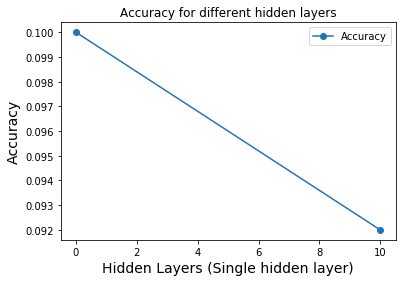

In [87]:
plt.plot(hidden_layers,accuracies,'o-',label="Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Hidden Layers (Single hidden layer)')
plt.legend()
plt.title("Accuracy for different hidden layers")

In [11]:
import numpy as np
 
def tanh(x):
    return np.tanh(x)
 
def tanh_deriv(x):
    return 1.0 - np.tanh(x)**2
 
def logistic(x):
    return 1/(1 + np.exp(-x))
 
def logistic_derivative(x):
    return logistic(x)*(1-logistic(x))
 
class NeuralNetwork:
    def __init__(self, layers, activation='tanh') :
        """
        layers: A list containing the number of units in each layer.
                Should contain at least two values
        activation: The activation function to be used. Can be
                "logistic" or "tanh"
        """
        if activation == 'logistic':
            self.activation = logistic
            self.activation_deriv = logistic_derivative
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_deriv = tanh_deriv
        self.num_layers = len(layers) - 1
        self.weights = [ np.random.randn(layers[i - 1] + 1, layers[i] + 1)/10 for i in range(1, len(layers) - 1) ]
        self.weights.append(np.random.randn(layers[-2] + 1, layers[-1])/10)
 
    def forward(self, x) :
        """
        compute the activation of each layer in the network
        """
        a = [x]
        for i in range(self.num_layers) :
            a.append(self.activation(np.dot(a[i], self.weights[i])))
        return a
 
    def backward(self, y, a) :
        """
        compute the deltas for example i
        """
        deltas = [(y - a[-1]) * self.activation_deriv(a[-1])]
        for l in range(len(a) - 2, 0, -1): # we need to begin at the second to last layer
            deltas.append(deltas[-1].dot(self.weights[l].T)*self.activation_deriv(a[l]))
        deltas.reverse()
        return deltas
 
    def fit(self, X, y, learning_rate=0.2, epochs=50):
        X = np.asarray(X)
        temp = np.ones( (X.shape[0], X.shape[1]+1))
        temp[:, 0:-1] = X  # adding the bias unit to the input layer
        X = temp
        y = np.asarray(y)
 
        for k in range(epochs):
            if k%10==0 : print ("***************** ", k, "epochs  ***************")
            I = np.random.permutation(X.shape[0])
            for i in I :
                a = self.forward(X[i])
                deltas = self.backward(y[i], a)
                # update the weights using the activations and deltas:
                for i in range(len(self.weights)):
                    layer = np.atleast_2d(a[i])
                    delta = np.atleast_2d(deltas[i])
                    self.weights[i] += learning_rate * layer.T.dot(delta)
 
    def predict(self, x):
        x = np.asarray(x)
        temp = np.ones(x.shape[0]+1)
        temp[0:-1] = x
        a = temp
        for l in range(0, len(self.weights)):
            a = self.activation(np.dot(a, self.weights[l]))
        return a

In [ ]:
def train_test_evaluate(X, y) :
    from sklearn.cross_validation import train_test_split 
    from sklearn.metrics import confusion_matrix, classification_report
    from sklearn.preprocessing import LabelBinarizer
    layers = [64, 100, 20, 10]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
    labels_train = LabelBinarizer().fit_transform(y_train)
    labels_test = LabelBinarizer().fit_transform(y_test)
 
    nn = NeuralNetwork(layers, 'logistic')
    nn.fit(X_train,labels_train,epochs=10)
    predictions = []
    for i in range(X_test.shape[0]) :
        o = nn.predict(X_test[i])
        predictions.append(np.argmax(o))
    print (confusion_matrix(y_test,predictions))
    print (classification_report(y_test,predictions))
    
train_test_evaluate(X, y)